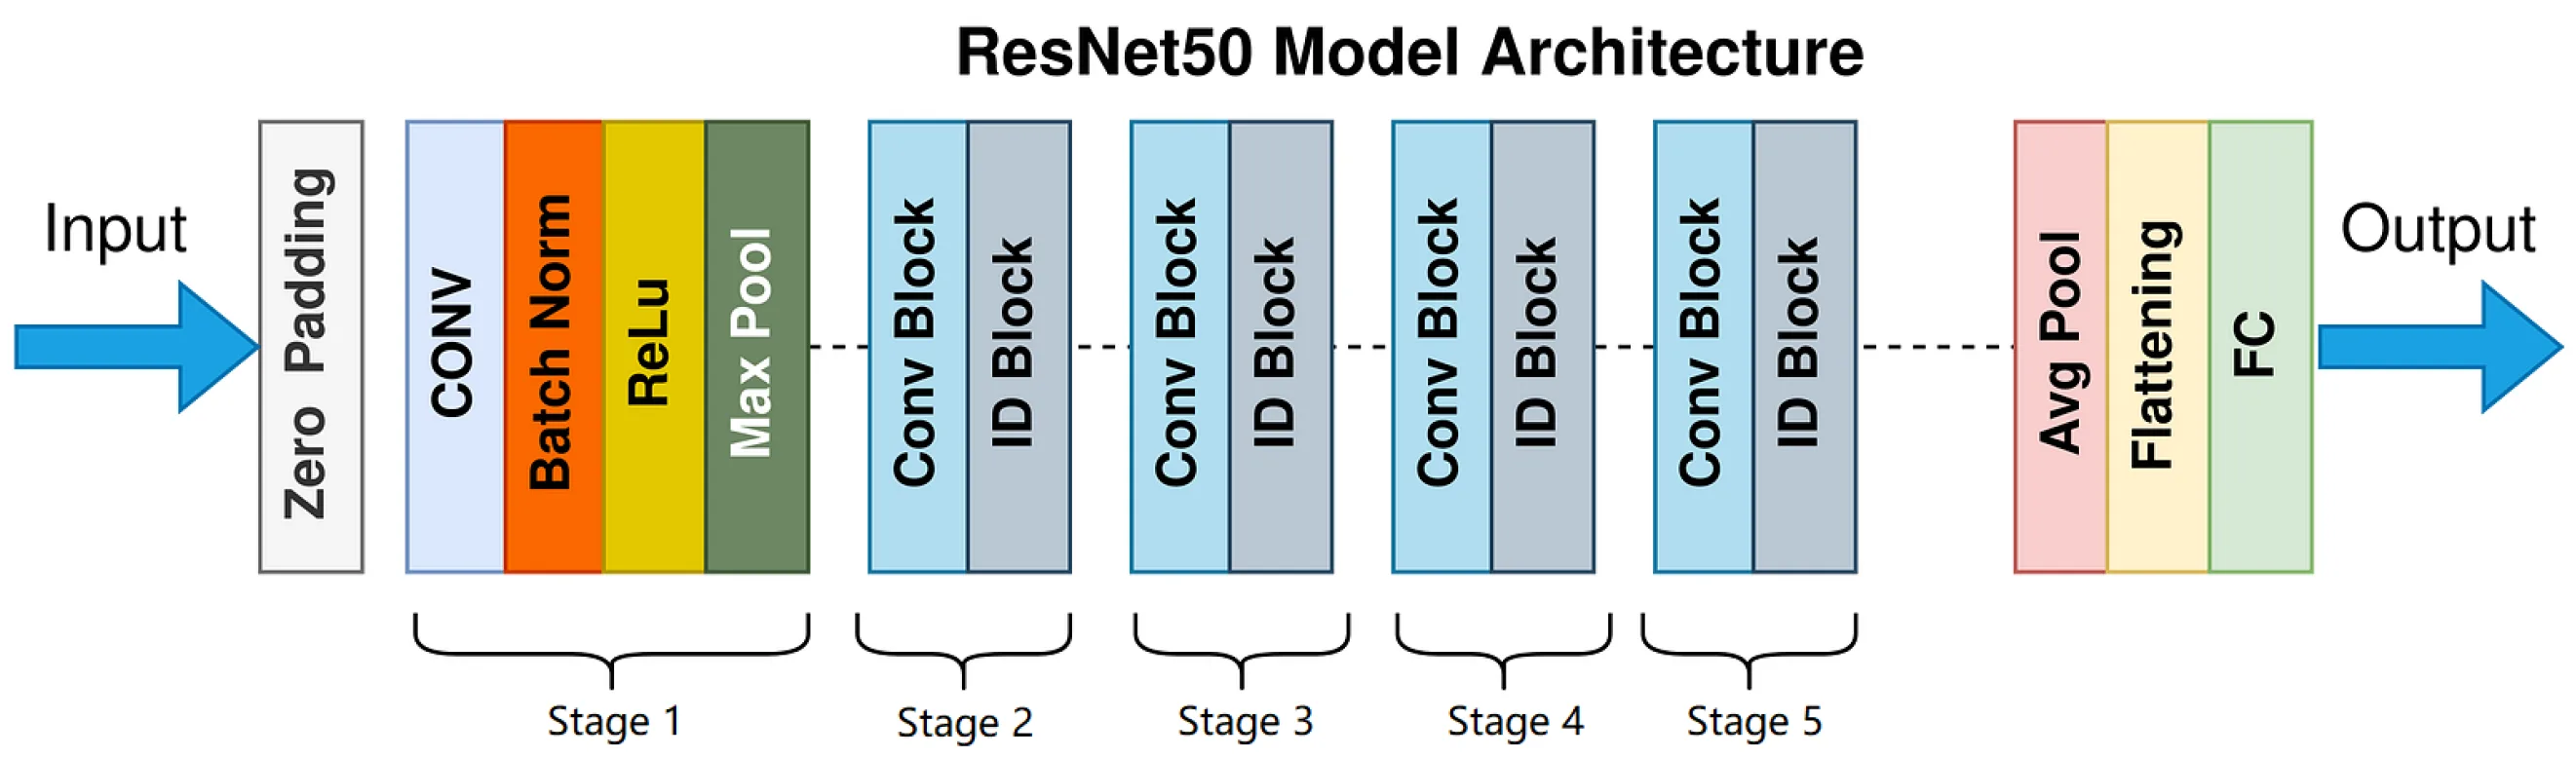

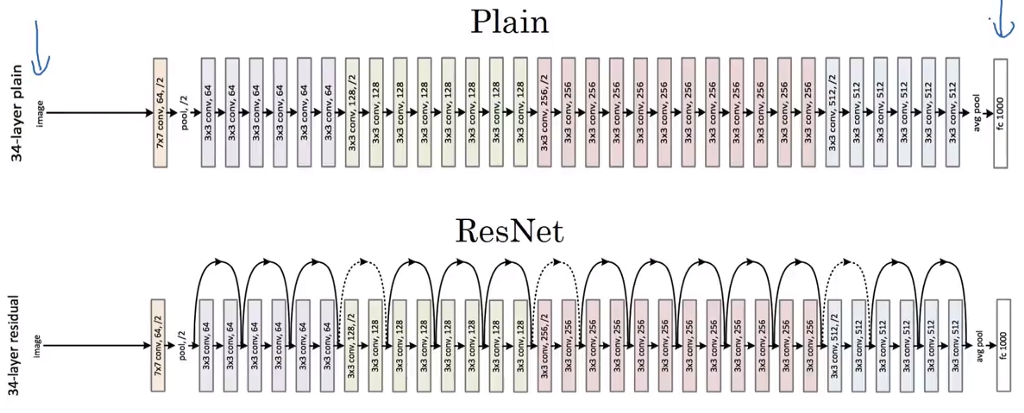

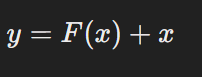

x — входной сигнал блока,
𝐹
(
𝑥
)
F(x) — выход обычных сверточных слоев, который пытается обучиться некоторой полезной функции,
𝑦
y — результат сложения 
𝐹
(
𝑥
)
F(x) и 
𝑥
x, который поступает на следующий слой.

ResNet-18 — состоит из 18 слоев.

ResNet-34 — более глубокая версия с 34 слоями.

ResNet-50 — версия с 50 слоями, где используется более сложная структура блоков.

ResNet-101 и ResNet-152 — очень глубокие версии с 101 и 152 слоями соответственно.

Классификация изображений: ResNet устанавливает стандарты в задачах ImageNet, что делает его основой для многих систем компьютерного зрения.

Детектирование объектов и сегментация: ResNet часто используется как базовая архитектура в таких моделях, как Mask R-CNN, Faster R-CNN и других, предназначенных для детектирования объектов и семантической сегментации.

Обработка видео: ResNet используется как базовая архитектура в решениях для распознавания активности на видео и в других видеозадачах.

Медицинские изображения: модели ResNet часто применяются для анализа изображений в области медицины, таких как рентген, МРТ и другие сканирования.

## 6. Преимущества и недостатки ResNet

Преимущества:
    
Простота и эффективность: ResNet легко обучается и решает проблему деградации в глубоких сетях.
    
Масштабируемость: можно увеличивать количество слоев без значительного ухудшения производительности.
    
Гибкость: архитектура ResNet адаптируется к различным задачам компьютерного зрения, таким как классификация, детектирование и сегментация.

Недостатки:

Большое количество параметров: несмотря на остаточные связи, глубокие модели ResNet содержат огромное количество параметров, что увеличивает вычислительные и ресурсные затраты.

Трудности с интерпретацией: хотя ResNet решает проблему затухания градиента, оставляет открытой проблему интерпретации глубоко обученных моделей.

ResNet стало одним из самых значительных достижений в области глубокого обучения. Благодаря остаточным блокам, модели этого семейства способны обучаться на сотнях слоев, преодолевая ограничения, присущие более простым архитектурам. Различные версии ResNet и их усовершенствования сегодня являются основой многих систем, включая задачи компьютерного зрения, обработки видео и медицинской диагностики.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
'''Класс `ResidualBlock` реализует базовый блок остаточной сети (ResNet), который используется для построения глубоких нейронных сетей. Вот краткое объяснение его структуры и функциональности:

1. **Наследование от `nn.Module`**: 
   - `ResidualBlock` наследуется от `nn.Module`, что является стандартом для всех слоев в PyTorch. Это позволяет использовать блок как часть общей архитектуры нейронной сети и автоматически отслеживать параметры для обучения.

2. **Конструктор (`__init__`)**: 
   - В конструкторе инициализируются ключевые компоненты блока, такие как свёртки и нормализация.

3. **Компоненты блока**:
   - `conv1`: Первая свёрточная операция, которая применяется к входным данным. Использует ядро размером 3x3 с заданной размерностью `in_channels` и `out_channels`. Шаг свёртки (`stride`) можно задавать при инициализации, что полезно для изменения размерности выходного пространства.
   - `bn1`: Нормализация данных после первой свёртки с помощью класса `BatchNorm2d` для стабилизации и ускорения обучения.
   - `conv2`: Вторая свёрточная операция, также с ядром 3x3, но всегда с шагом 1. Число выходных каналов сохраняется.
   - `bn2`: Нормализация данных после второй свёртки.

4. **Параметр `downsample`**:
   - Опциональная операция, которая может изменять размерность входного тензора, чтобы она совпадала
   с размерностью выходного тензора из `conv2`. Это нужно для корректного сложения тензоров в рамках
   остаточного соединения, особенно когда изменяется количество каналов или размер пространственного разрешения.

5. **Мотивация**:
   - Основная идея остаточных блоков заключается в добавлении "shortcut"
   или остаточного соединения, позволяющего градиентам во время обратного прохода
   эффективно распространяться через сеть, что способствует обучению более глубоких моделей.
   При прямом проходе остаточное соединение позволяет входу проходить напрямую, добавляя лишь
   небольшое корректирующее изменение, вычисленное свёрточными слоями блока.
'''

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample   # Для изменения размерности (например, при увеличении числа каналов)
    '''Метод `forward` в классе `ResidualBlock` определяет, как данные проходят через блок при прямом распространении. Вот подробное объяснение процесса:

1. **Сохранение входного сигнала**:
   - `identity = x`: Входной сигнал `x` сохраняется как `identity` для последующего использования в остаточной связи (skip connection).

2. **Первая свёртка и активация**:
   - `out = self.conv1(x)`: Применяется первая свёрточная операция к входным данным.
   - `out = self.bn1(out)`: Выполняется нормализация результата с помощью пакетной нормализации.
   - `out = F.relu(out)`: Применяется функция активации ReLU, чтобы ввести нелинейность в модель.

3. **Вторая свёртка и нормализация**:
   - `out = self.conv2(out)`: Применяется вторая свёрточная операция.
   - `out = self.bn2(out)`: Выполняется пакетная нормализация для стабилизации обучения.

4. **Применение downsample, если необходимо**:
   - Если `self.downsample` не `None`, выполняется изменение размерности (`identity = self.downsample(x)`).
   Это используется для приведения размерности `identity` в соответствие с
   выходными данными блока, если изменяется количество каналов или размерность
   (например, за счет использования большего `stride` в `conv1`).
   5. **Остаточная связь**:
   - `out += identity`: К результату второй свёртки добавляется сохранённый
   входной сигнал `identity`. Эта операция добавления позволяет модели хранить 
   исходные характеристики, помогая при обратном распространении градиента.

6. **Финальная активация**:
   - `out = F.relu(out)`: Применяется ReLU к сумме, что вводит еще одну
   нелинейность. Это улучшает представительные возможности блока.

7. **Возврат результата**:
   - `return out`: Финальный выход блока возвращается наверх по цепочке вызовов.

Этот метод демонстрирует ключевую идею остаточных сетей: вместо того чтобы
обучать модель полностью с нуля, она учится обучать небольшое отклонение
от входного сигнала, упрощая оптимизацию и позволяя эффективно создавать более глубокие сети.'''
    
    def forward(self, x):
        identity = x  # сохраняем входной сигнал для остаточной связи

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # добавляем входной сигнал к выходу блока
        out = F.relu(out)
        return out

In [9]:
'''1. **Конструктор `__init__`**: 
   - Принимает три параметра: `block`, `layers` и `num_classes`.
   - `block` задает тип блока, который будет использоваться (например, стандартный Residual Block или Bottleneck Block).
   - `layers` — список, задающий количество блоков в каждом из четырех основных слоев сети.
   - `num_classes` — количество классов для задачи классификации.

2. **Начальные слои**:
   - `conv1`: Сверточный слой, который преобразует входное изображение (например, RGB) в 64-канальное представление.
   - `bn1`: Нормализация батча для стабилизации обучения.
   - `relu`: Функция активации ReLU.
   - `maxpool`: Пулинг для уменьшения размерности.

3. **Основные блоки ResNet**:
   - Четыре последовательных слоя (`layer1`, `layer2`, `layer3`, `layer4`), которые создаются с помощью
   метода `_make_layer`.
   - Каждый слой увеличивает количество фильтров (64, 128, 256 и 512 соответственно) и включает указанное
   число блоков, переданных через `layers`.

4. **Заключительные слои**:
   - `avgpool`: Адаптивный средний пулинг, который создает выходной тензор размера 1x1 для каждого канала.
   - `fc`: Полносвязный слой, который преобразует сверточное представление в вероятности классов. Выходной
   размер совпадает с `num_classes`.'''

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Начальные слои
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Основные блоки ResNet
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Заключительные слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        '''1. **Параметры**:
   - `block`: Вероятно, это класс (например, `BasicBlock` или `Bottleneck`), который используется
   для определения базового строительного блока сети.
   - `out_channels`: Количество выходных каналов для каждого сверточного слоя внутри блока.
   - `blocks`: Количество блоков, которые нужно создать в этом слое.
   - `stride`: Шаг, используемый в первом сверточном слое блока.

2. **Downsample**:
   - Если шаг (`stride`) не равен 1 или количество входных каналов не совпадает с количеством выходных каналов,
   создается слой `downsample`. Это обычно происходит, когда необходимо изменить размерность входа,
   часто для уменьшения разрешения или для согласования размерностей.
   - Слой downsample состоит из сверточного слоя `Conv2d` с размером ядра 1 для изменения
   глубины карты признаков, после которого следует слой нормализации `BatchNorm2d`.

3. **Список слоев**:
   - Первый блок добавляется в список `layers` с возможной функцией downsample.
   - Оставшиеся блоки (от `range(1, blocks)`) добавляются к списку без изменения 
   шага или downsample, то есть сохраняется прежнее количество входных и выходных каналов.

4. **Возврат**:
   - `nn.Sequential(*layers)`: Список слоев упаковывается в контейнер PyTorch `Sequential`, 
   который представляет собой базовый строительный блок для создания сложных архитектур нейронных
   сетей. Это позволяет последовательно соединить слои в единый модуль.

Такое определение `_make_layer` помогает создать части ResNet, в которых остаточные соединения
и понижение дискретизации (downsampling) важны для производительности и структуры модели.
        '''
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [10]:
# Создание модели ResNet-18
def ResNet18(num_classes=1000):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

In [11]:
# Пример использования модели
if __name__ == "__main__":
    # Создаем модель ResNet-18
    model = ResNet18(num_classes=1000)

    # Подаем пример изображения размером 224x224 с 3 каналами (RGB)
    x = torch.randn(1, 3, 224, 224)
    output = model(x)

    print(f"Output shape: {output.shape}")   # Ожидаем [1, 1000] для ImageNet-классификации

Output shape: torch.Size([1, 1000])


Внесенные изменения:
downsample в ResidualBlock: если stride ≠ 1 или если количество входных и выходных каналов не совпадает, используется downsample для преобразования размерности входного тензора в согласование с выходом.
В функции _make_layer изменен механизм передачи числа каналов между слоями.  Размерность входов/выходов корректно поддерживается при увеличении количества каналов.